In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

In [2]:
#Initial data pull to obtain pricing data using the yfinance API
class Portfolio:
    
    #Initializes the object with a list of ticker symbols and the period to pull pricing data from as attributes
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    #Concatenates the monthly Adjusted Close prices for each ticker to a dataframe
    def get_prices(self):
        
        price_df = pd.DataFrame()
    
        for ticker in self.tickers:
            frame = pdr.get_data_yahoo(ticker, start=self.start_date, end=self.end_date, interval='1mo')
            frame = frame.rename(columns={'Adj Close' : f"{ticker}_adj_close"})
            prices = frame.loc[:,f"{ticker}_adj_close"]
            price_df = pd.concat([price_df, prices], axis=1)
            
        return price_df
    
    #Creates a new dataframe containing the lognormal returns of the pricing data
    def get_returns(self):
        
        returns_df = self.get_prices()
        
        for column in returns_df.columns:
            returns_df[f"{column.split('_')[0]}_returns"] = np.log(returns_df[column] / returns_df[column].shift(1))
            returns_df = returns_df.drop(column, axis=1)
        
        return returns_df.dropna()

In [3]:
from fredapi import Fred
from scipy.optimize import minimize

In [4]:
#Optimizing the portfolio for Sharpe Ratio
def optimize(df, tickers):
    
    #Generating Expected Return and Standard Deviation for sample portfolio
    covar_matrix = df.cov()*12
    
    def std_dev(weights, covar_matrix):
        variance = weights.T @ covar_matrix @ weights
        return np.sqrt(variance)
    
    def exp_ret(df, weights):
        return np.sum(df.mean()*weights)*12
    
    #Federal Reserve Bank of St. Louis API to use current 10-Year Treasury as Risk-Free Rate
    # fred = Fred(api_key=)
    # rf = (fred.get_series_latest_release('GS10') / 100).iloc[-1]
    rf = 0.0421
    
    #Sharpe Ratio computation - ratio of return premium to level of risk
    def sharpe(weights, df, covar_matrix, rf):
        return -((exp_ret(df, weights) - rf) / std_dev(weights, covar_matrix))
    
    constraints = {'type':'eq', 'fun' : lambda weights: np.sum(weights) - 1}
    #Setting limit on size of each position
    bounds = [(0.00, 0.5) for i in range(len(tickers))]
    
    init_weights = np.array([1/len(tickers)] * len(tickers))
    
    optimized_results = minimize(sharpe, init_weights, args=(df, covar_matrix, rf), method='SLSQP', constraints=constraints, bounds=bounds)
    optimized_weights = optimized_results.x
    
    return np.round_(optimized_weights, 4)

In [5]:
test_portfolio = Portfolio(['SPY', 'BND', 'GLD', 'QQQ', 'VTI'], dt.datetime(2020, 1, 1), dt.datetime.today())
portfolio_frame = test_portfolio.get_returns()
results = optimize(portfolio_frame, test_portfolio.tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
#Prior functionality is used to generate an array of weights that will yield the highest Sharpe Ratio
#Function below applies the weights array to the portfolio so that the optimized returns are computed
def implement_weights(df, weights):
    
    calculate_returns = lambda row_: np.sum(row_ * weights)
    
    df['portfolio_returns'] = df.apply(calculate_returns, axis=1)
    
    return df

In [7]:
opt_portfolio = implement_weights(portfolio_frame, results)

In [8]:
#Viewing the expected return, volatility, and Sharpe Ratio of the optimized portfolio
def metrics(df):
    
    # fred = Fred(api_key=)
    # rf = (fred.get_series_latest_release('GS10') / 100).iloc[-1]
    rf = 0.0421
    
    er = (df['portfolio_returns'].mean() * 12)
    
    stdev = np.std(df['portfolio_returns']) * np.sqrt(12)
    
    sharpe = (er - rf) / stdev
    
    print(f"The Expected Return of the portfolio is: {round(er*100, 2)}%")
    print(f"The Volatility of the portfolio is: {round(stdev*100, 2)}%")
    print(f"The Sharpe Ratio of the portfolio is: {round(sharpe, 4)}")

In [9]:
metrics(opt_portfolio)

The Expected Return of the portfolio is: 13.01%
The Volatility of the portfolio is: 15.26%
The Sharpe Ratio of the portfolio is: 0.5766


In [10]:
#Creates a feature displaying how an investment in the sample portfolio would perform over the specified timeframe
def investment_growth(df, size, source):
    
    df = df.reset_index(drop=True)
        
    dollar_returns = pd.Series(name=f"{source}_growth")
    
    dollar_returns[0] = int(size)
        
    for i in range(1,len(df)):
        dollar_returns[i] = (1+df.loc[i,f"{source}_returns"]) * dollar_returns[i-1]
        
    df = pd.concat([df, dollar_returns], axis=1)

    return df

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [12]:
#Visualization to show how the sample portfolio would perform relative to the market
def display_performance(df, obj):
    
    df = df.reset_index(names=['Date'])
    df['Year'] = df['Date'].apply(lambda row_: row_.year)
    df = investment_growth(df, 1000000, 'portfolio')
    
    data = pdr.get_data_yahoo('SPY', start=obj.start_date, end=obj.end_date, interval = '1mo')
    prices = data['Adj Close']
    market_frame = np.log(prices / prices.shift(1)).dropna()
    market_frame = market_frame.reset_index()
    market_frame['Year'] = market_frame['Date'].map(lambda row_: row_.year)
    market_frame = market_frame.rename(columns={'Adj Close':'market_returns'})
    market_frame = investment_growth(market_frame, 1000000, 'market')
    
    fig, ax = plt.subplots(figsize=(10,7))
    
    sns.lineplot(df, x=df['Date'], y=df['portfolio_growth'], color='blue', marker='o', errorbar=None)
    sns.lineplot(x=market_frame['Date'], y=market_frame['market_growth'], color='grey', marker='o', errorbar=None)
    
    plt.title('Portfolio Performance versus the Market')
    plt.xlabel('Date')
    plt.ylabel('Investment Size')
    
    ax.yaxis.set_major_formatter('${x:,.0f}')
    
    plt.grid(True)
    
    plt.legend(['Portfolio', 'Market'], loc='upper right', bbox_to_anchor=(1.2,1))

    return None

[*********************100%%**********************]  1 of 1 completed


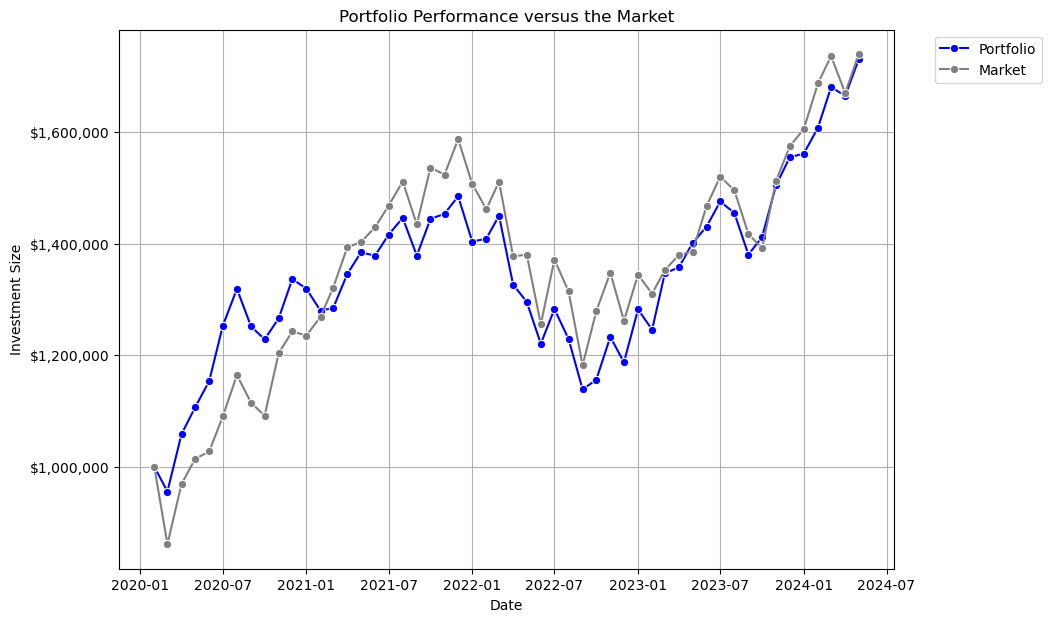

In [13]:
display_performance(opt_portfolio, test_portfolio)

In [14]:
#Visualization to show a distribution of the returns of the sample portfolio
def show_returns_distribution(df):
    
    returns_array = df['portfolio_returns'] * 100
    
    n_bins = int(np.sqrt(len(df)))
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='-')
    
    ax.hist(returns_array, bins=n_bins)
    
    ax.set_title('Distribution of Portfolio Returns')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Count')
    
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    return None

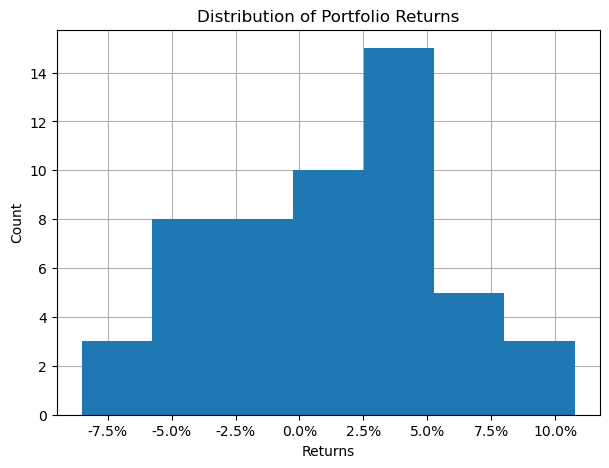

In [15]:
show_returns_distribution(opt_portfolio)

In [16]:
#Computing the beta of the sample portfolio to the market
def get_beta(df, obj):
    
    df = df.reset_index(drop=True)
    
    data = pdr.get_data_yahoo('SPY', start=obj.start_date, end=obj.end_date, interval = '1mo')
    prices = data['Adj Close']
    market_frame = np.log(prices / prices.shift(1)).dropna()
    market_frame = market_frame.reset_index()
    market_frame['Year'] = market_frame['Date'].map(lambda row_: row_.year)
    market_frame = market_frame.rename(columns={'Adj Close':'market_returns'})
    
    beta_frame = pd.concat([df['portfolio_returns'], market_frame['market_returns']], axis=1)
    
    beta_coeff = beta_frame['portfolio_returns'].cov(beta_frame['market_returns'])
    
    market_var = np.var(beta_frame['market_returns'])
    
    return beta_coeff / market_var

In [17]:
get_beta(opt_portfolio, test_portfolio)

[*********************100%%**********************]  1 of 1 completed


0.6825371157150918

In [18]:
from statistics import NormalDist

In [19]:
#Computing the Value at Risk and Conditional Value at Risk of the portfolio
def get_var(df, var_type, size, interval):
    
    er = df['portfolio_returns'].mean()
    
    stdev = np.std(df['portfolio_returns'])
    
    var_return = NormalDist(mu=er, sigma=stdev).inv_cdf(interval)
    
    if var_type == 'VaR':
        
        var_amount = -(round(var_return * size,2))
        
        return f"Value-at-Risk: {var_amount}"
    
    if var_type == 'CVaR':
        
        shortfall_returns = df.loc[df['portfolio_returns'] < var_return, 'portfolio_returns'].mean()
        
        cvar_amount = -(round(shortfall_returns * size, 2))
        
        return f"${cvar_amount}"

In [20]:
get_var(opt_portfolio, 'CVaR', 1000000, 0.025)

'$85229.09'